# Computing planar potential flows with package `ViscousFlow`

In [1]:
using ViscousFlow

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousFlow/2kdbn.ji for ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1240


In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


In [3]:
using LinearAlgebra

### First, some generalities

In [4]:
Δx = 0.01
xlim = (-3,3)
ylim = (-3,3)
g = PhysicalGrid(xlim,ylim,Δx)

w = Nodes(Dual,size(g))
L = plan_laplacian(size(w),with_inverse=true)

xg,yg = coordinates(w,g);

## Flat plate

In [29]:
n = 50
body = Plate(1.0,n)
ds = 1.0/n

xc = 0.0; yc = 0.0
T = RigidTransform((xc,yc),-π/3)
T(body)

Plate with 50 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): -1.0471975511965976


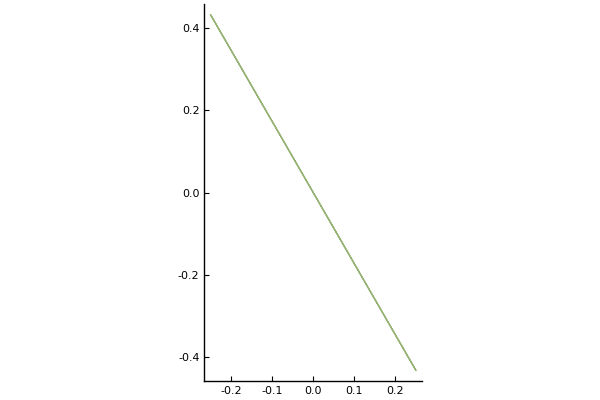

In [30]:
plot(body)

In [31]:
X = VectorData(0.5*(body.x[1:end-1]+body.x[2:end]),0.5*(body.y[1:end-1]+body.y[2:end]))
s = 0.5*(body.x̃[1:end-1]+body.x̃[2:end]);

f = ScalarData(X);

In [32]:
θ = acos.(2*body.x̃);

In [33]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 2.0


In [34]:
regop = Regularize(X,Δx,I0=origin(g),weights=ds,ddftype=Fields.Yang3)

Regularization/interpolation operator with non-filtered interpolation
  DDF type ViscousFlow.Fields.Yang3
  49 points in grid with cell area 0.0001


In [35]:
Hmat = RegularizationMatrix(regop,f,w);
Emat = InterpolationMatrix(regop,w,f);

In [36]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=false,store=true,isposdef=true)

Saddle system with 49 constraints and
   State of type Nodes{Dual,616,616,Float64}
   Force of type ScalarData{49,Float64}


In [37]:
#Θ = diagm(1.0./sqrt.(1/4 .- s.^2));
#Θ = diagm(diff(θ)./ds);

ψb = ScalarData(X)
ψb .= 1.0
@time ψ0,f0 = PS\(w,ψb)

Θ = diagm(f0);

  0.074955 seconds (53 allocations: 14.478 MiB, 4.89% gc time)


In [38]:
H̃mat = deepcopy(Hmat);
H̃mat.M .= H̃mat.M*Θ;
Ẽmat = deepcopy(Emat);

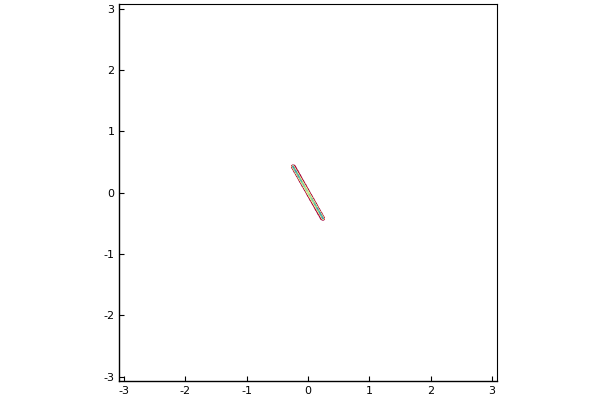

In [39]:
f .= 1;
plot(xg,yg,Hmat*f)

In [40]:
PS̃ = SaddleSystem((w,f),(L⁻¹,H̃mat,Emat),issymmetric=false,store=true,isposdef=true)

Saddle system with 49 constraints and
   State of type Nodes{Dual,616,616,Float64}
   Force of type ScalarData{49,Float64}


In [41]:
ψ = Nodes(Dual,w)
ψtot = zero(ψ);

In [44]:
U∞ = 1.0
ψb .= -U∞*(X.v .- body.cent[2]) # Translation in x direction
#ψb .= 1.0

ψ̃b = deepcopy(ψb);
#ψ̃b.data .= Θ*ψ̃b.data;

@time ψ,f = PS\(w,ψb)

@time ψ,f̃ = PS̃\(w,ψ̃b)

ψtot .= ψ .+ yg' .- body.cent[2]; # adding the free-stream streamfunction

  0.072758 seconds (53 allocations: 14.478 MiB)
  0.072807 seconds (66 allocations: 14.478 MiB, 5.07% gc time)


In [47]:
S = Matrix(PS.S)
S̃ = Matrix(PS̃.S);

In [50]:
F = svd(S);
F̃ = svd(S̃);

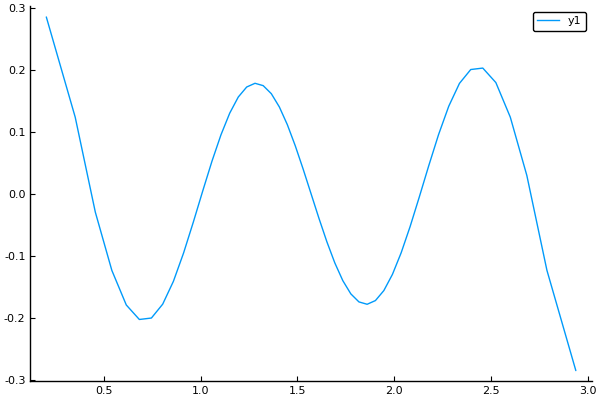

In [57]:
θ = acos.(2*s)
j = 6
plot(θ,F̃.U[:,j])
#plot!(θ,F.U[:,j])

In [45]:
ψc = deepcopy(ψ)

p = length(f)
ep = zero(f)
ep[p] = 1.5
ep[p-1] = -0.5
#ep[p] = 1.0
Γ0 = (f0 - sum(f0)*ep)'*f̃
println(Γ0)

f̃c = deepcopy(f̃)
ψ̃0 = -(Γ0 - f0.data'*f̃.data)/sum(f0)
f̃c.data .-= ψ̃0*ones(length(f0));

ψc .= -PS̃.A⁻¹B₁ᵀ(f̃c);

ψctot = zero(ψ);
ψctot .= ψc .+ yg' .- body.cent[2] #.+ ψ̃0; # adding the free-stream streamfunction

-0.014421166273441111


In [776]:
ones(length(f0))'*(f0.data*ep' - ep*f0.data')

1×49 Adjoint{Float64,Array{Float64,1}}:
 0.00109025  0.000230072  0.00029747  …  0.00029747  0.00507297  -0.0134384

In [25]:
plot(θ,f0 - sum(f0)*ep)
plot!(θ,f0)

UndefVarError: UndefVarError: θ not defined

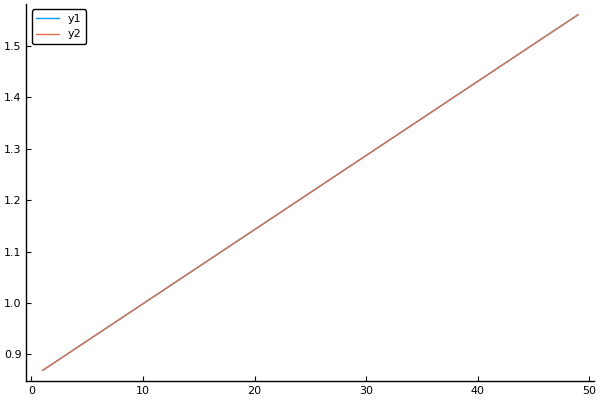

In [759]:
plot(S̃*f̃c)
plot!(ψb .- ψ̃0)

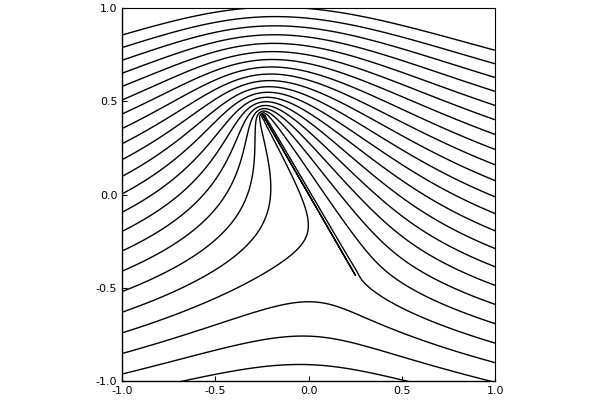

In [46]:
plot(xg,yg,ψctot,linecolor=:black,levels=range(0.5,3,length=31),xlim=(-1,1),ylim=(-1,1))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

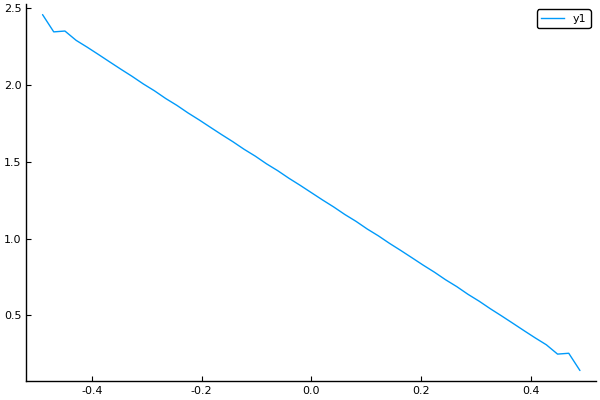

In [544]:
plot(s,f̃c.data)

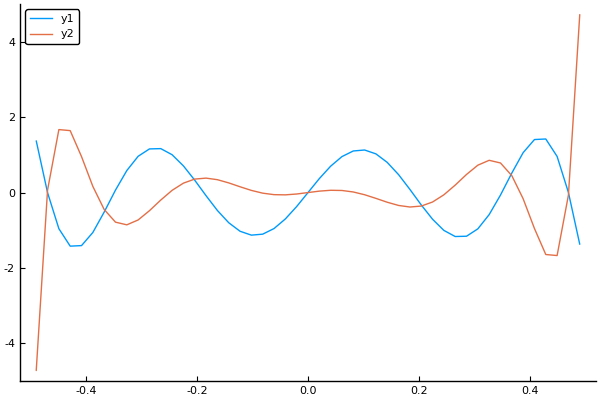

In [602]:
plot(s,2π*F̃.Vt[8,:])

#plot!(s,sin.(2*acos.(s*2))./sin.(acos.(s*2)))
#plot!(s,sin.(15*acos.(s*2))./sin.(acos.(s*2)))
plot!(s,cos.(9*acos.(s*2))+sin.(8*acos.(s*2))./sin.(acos.(s*2)))

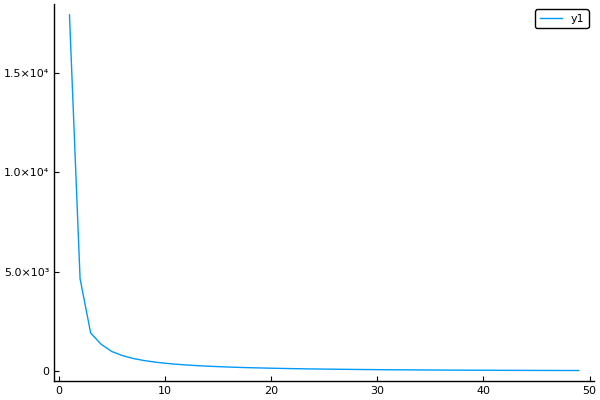

In [207]:
plot(F.Vt)

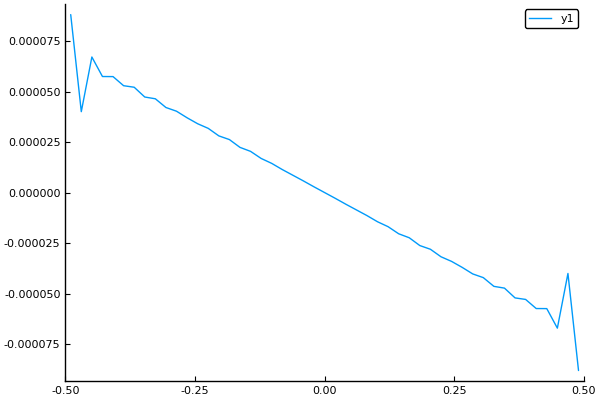

In [289]:
plot(s,f̃,xlim=(-0.5,0.5))
#plot!(f)

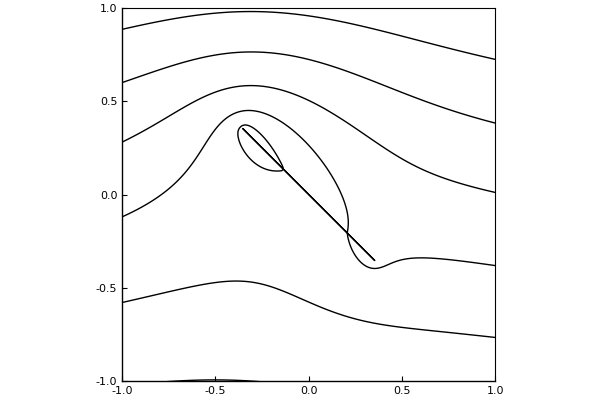

In [549]:
plot(xg,yg,ψctot,linecolor=:black,levels=range(-5,5,length=30),xlim=(-1,1),ylim=(-1,1))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

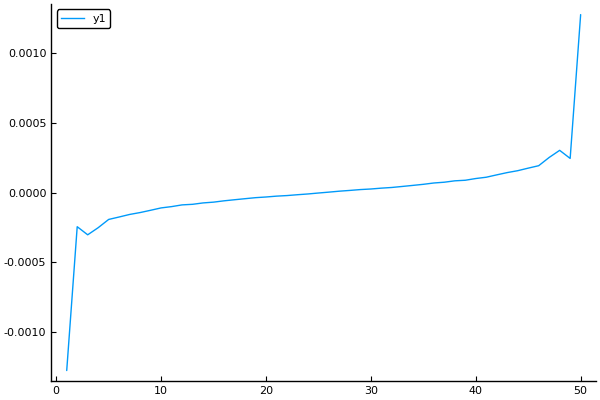

In [71]:
plot(f)

### Circles

#### Now create a circular shape, with discrete points and associated regularization and interpolation operator

In [275]:
n = 150

R = 1.0
body = Circle(R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the circle
xc = 0.0; yc = 0.0
T = RigidTransform((xc,yc),0.0)
T(body)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


#### Set up the coordinates and other useful vectors

In [276]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [277]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 2.094241988335652


In [278]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=Fields.Yang3)

Symmetric regularization/interpolation operator with non-filtered interpolation
  DDF type ViscousFlow.Fields.Yang3
  150 points in grid with cell area 0.0004


In [279]:
Hmat,Emat = RegularizationMatrix(regop,f,w);

#### And now create the saddle-point system

In [280]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 150 constraints and
   State of type Nodes{Dual,600,600,Float64}
   Force of type ScalarData{150,Float64}


#### Create some data structures for general use

In [281]:
ψb = ScalarData(X)
w = Nodes(Dual,size(g))
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

In [282]:
ψb .= -(body.x .- body.cent[1])
@time ψ,f = PS\(w,ψb)

  0.140293 seconds (157 allocations: 24.739 MiB, 4.76% gc time)


(Dual nodes in a (nx = 600, ny = 600) cell grid of type Float64 data
  Number of Dual nodes: (nx = 600, ny = 600), [-0.08485266662270885, -0.0847782364175158, -0.08455507637780812, -0.08418357800212575, -0.08366439302485564, -0.08299843227286814, -0.08218686406761722, -0.08123111217550764, -0.08013285331012485, -0.07889401419070956  …  -0.0775167681620376, -0.07889401419070956, -0.08013285331012485, -0.08123111217550764, -0.08218686406761722, -0.08299843227286813, -0.08366439302485562, -0.08418357800212575, -0.08455507637780811, -0.0847782364175158])

#### Plot the result

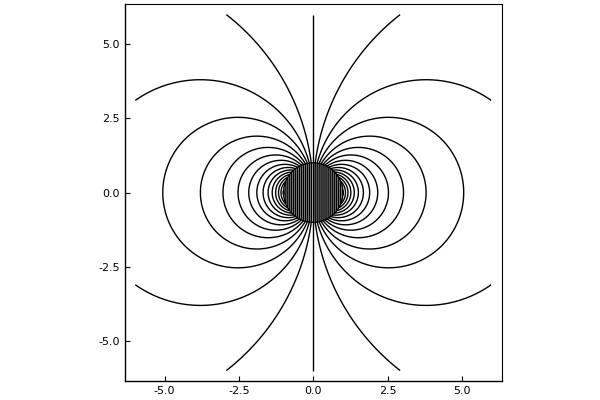

In [283]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=31))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

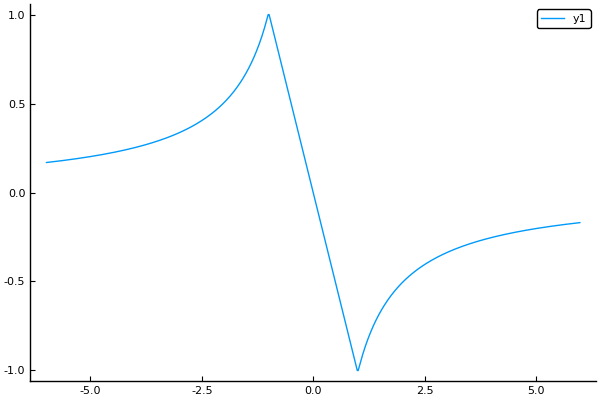

In [287]:
plot(xg,ψ[:,301])

Plot the result in a frame in which cylinder is stationary

In [288]:
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ xg .- body.cent[1]; # adding the free-stream streamfunction

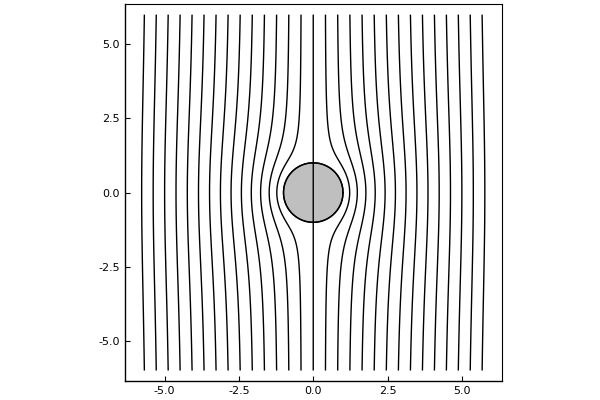

In [289]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψtot,linecolor=:black,levels=range(-6,6,length=31))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Compare the generated vortex sheet `f/ds` with the exact solution

In [290]:
θ = range(0,2π,length=n+1)
fex = -2*cos.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

0.025856302550391064

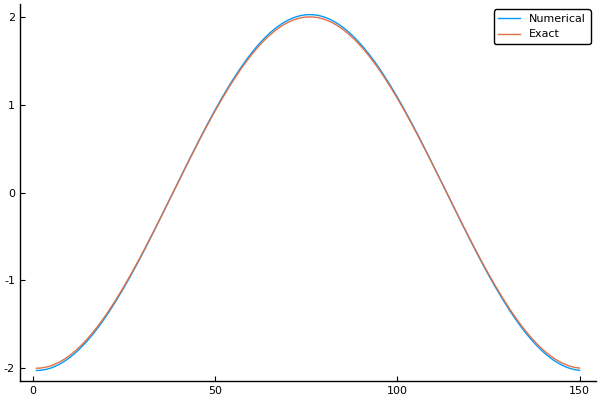

In [291]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

#### Now try storing the Schur matrix

In [292]:
L⁻¹(w::T) where {T} = L\w
PSstore = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,store=true)

Saddle system with 150 constraints and
   State of type Nodes{Dual,600,600,Float64}
   Force of type ScalarData{150,Float64}


This way is significantly faster

  0.072898 seconds (53 allocations: 13.738 MiB)


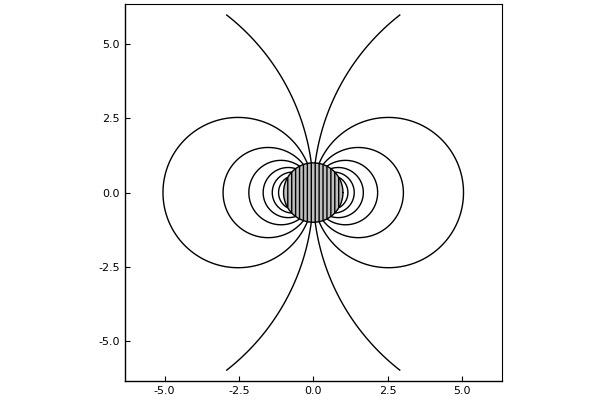

In [294]:
ψb = ScalarData(X);
w = Nodes(Dual,size(g));
ψb .= -(body.x .- body.cent[1]);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PSstore\(w,ψb)
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

But there is more noise in the force

In [295]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f./ds-fex,Inf)

0.041201956041402976

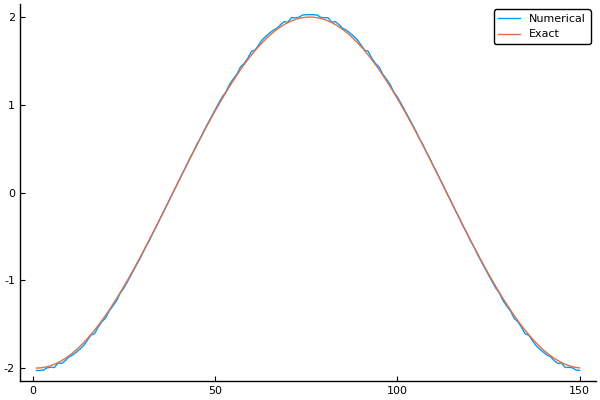

In [296]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

So let's filter it

In [297]:
regopfilt = Regularize(X,Δx,I0=origin(g),weights=ds,issymmetric=true,ddftype=Fields.Yang3,filter=true)
H̃mat = RegularizationMatrix(regopfilt,f,w);
Ẽmat = InterpolationMatrix(regopfilt,w,f);

In [298]:
f̃ = ScalarData(X);

In [299]:
P(f) = Ẽmat*(H̃mat*f)
PScond = SaddleSystem((w,f̃),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,conditioner=P,store=true)

Saddle system with 150 constraints and
   State of type Nodes{Dual,600,600,Float64}
   Force of type ScalarData{150,Float64}


  0.083010 seconds (61 allocations: 16.485 MiB, 9.91% gc time)


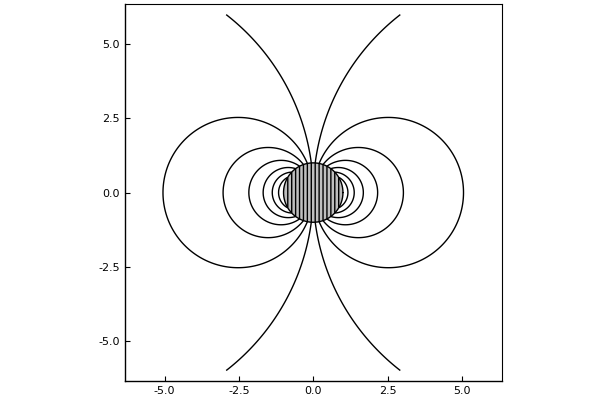

In [300]:
ψb = ScalarData(X);
w = Nodes(Dual,size(g));
ψb .= -(body.x .- body.cent[1]);
ψ = Nodes(Dual,w);
@time ψ,f̃ = PScond\(w,ψb)
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [301]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f̃./ds-fex,Inf)

0.037284857861969334

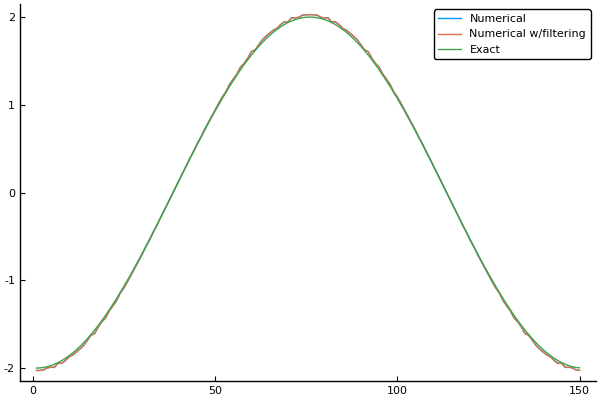

In [302]:
plot(f./ds,label="Numerical")
plot!(f̃./ds,label="Numerical w/filtering")
plot!(fex,label="Exact")

### Now try using a double-layer potential to set the interior solution

In [303]:
dlayer = DoubleLayer(body,regop,ψ)

Double-layer potential mapping
  from 150 scalar-valued point data of Float64 type
  to a 600 x 600 grid of Dual nodal data


In [304]:
ψb .= -(body.x .- body.cent[1])
@time ψd,fd = PS\(w - dlayer(ψb),0.5*ψb)

  0.774093 seconds (1.73 M allocations: 141.380 MiB, 9.33% gc time)


(Dual nodes in a (nx = 600, ny = 600) cell grid of type Float64 data
  Number of Dual nodes: (nx = 600, ny = 600), [-0.03881500132046516, -0.04120316051691488, -0.047703283830615714, -0.044604942798582375, -0.027706990875601762, -0.04809407693494821, -0.0365247928801993, -0.047344491561800484, -0.03631219623977787, -0.03981297581622019  …  -0.03781778421628269, -0.039812975816203106, -0.03631219623979592, -0.04734449156179859, -0.036524792880178306, -0.048094076934957854, -0.027706990875606907, -0.04460494279856744, -0.047703283830611044, -0.04120316051692281])

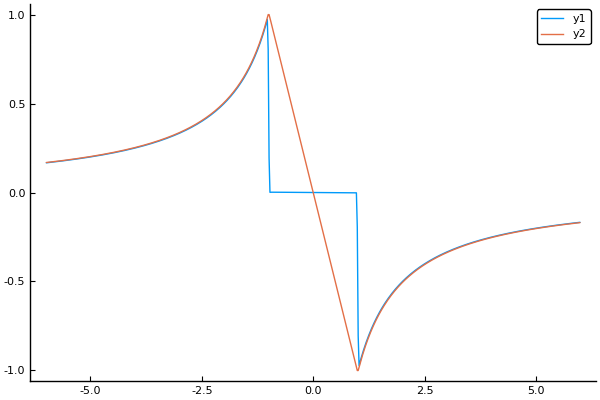

In [305]:
plot(xg,ψd[:,301])
plot!(xg,ψ[:,301])

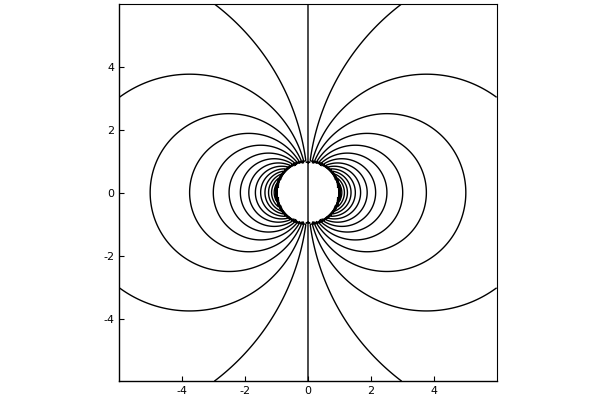

In [306]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψd,linecolor=:black,levels=range(-1,1,length=31))
#plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

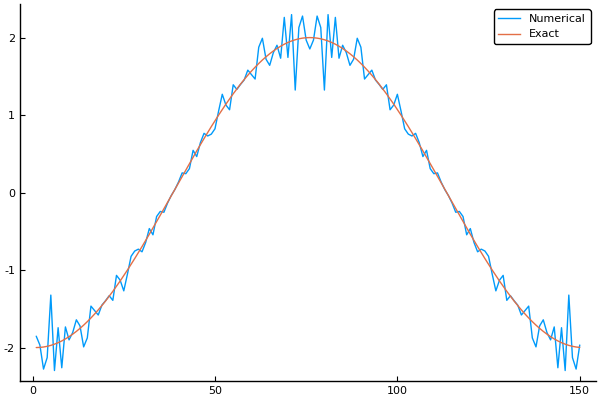

In [307]:
plot(2fd./ds,label="Numerical")
plot!(fex,label="Exact")

### Now flow about a cylinder with net circulation

#### Set up some helpful operators

`oB` is the basis vector for uniform Lagrange point data. As a transpose, it is a summation operator on Lagrange point data.

In [308]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [309]:
S = Matrix(PS.S);

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [310]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

#### Now set the problem parameters

In [311]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 1;

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [312]:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

#### Check that this `f` gives correct circulation

In [313]:
sum(f)

1.0000000000000004

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [314]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

1.6236279599420573

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [315]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

In [317]:
q = curl(ψ)/Δx;

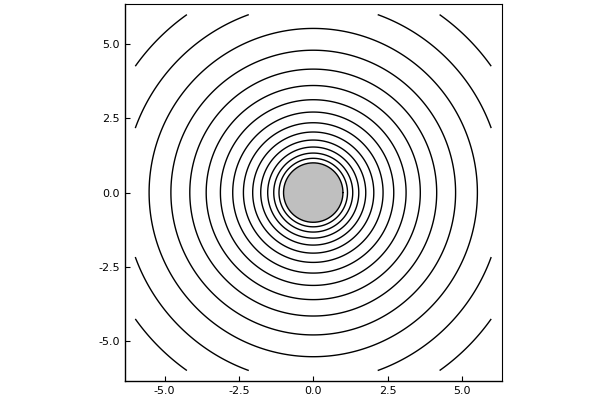

In [319]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

#### Plot the vertical velocity along a horizontal line

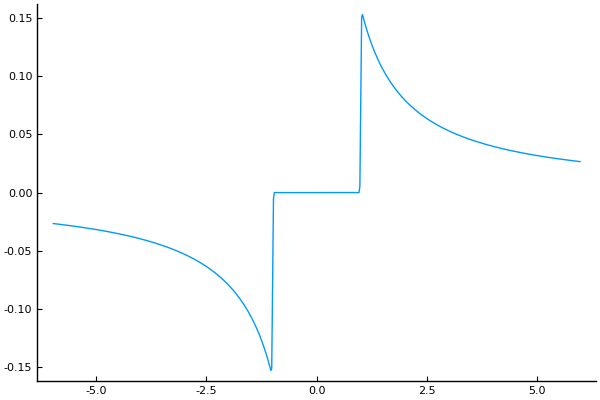

In [321]:
jcent = size(g,2) ÷ 2
xu,yu = coordinates(q.v,g)
plot(xu,q.v[:,jcent],legend=:false)

#### Plot the streamfunction along a horizontal line

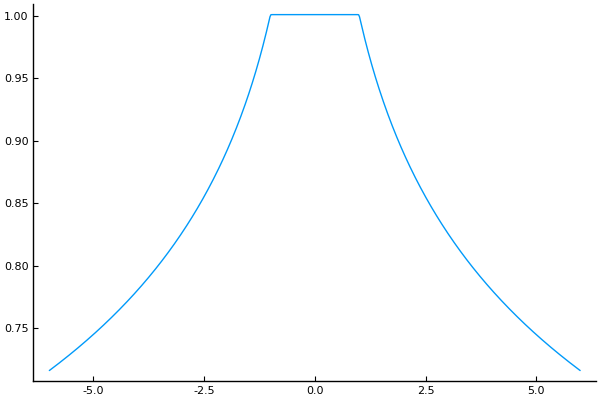

In [322]:
jcent = size(g,2) ÷ 2
plot(xg,ψ[:,jcent],legend=:false)

### Now flow about another shape with net circulation

In [132]:
#body = Rectangle(1.0,1.0,100)
body = Circle(1.0,300)
#body = Plate(1.0,50)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the shape
xc = 0.5; yc = 0.0; α = π/3
T = RigidTransform((xc,yc),-α)
T(body)

normb = normalmid(body)
dsb = dlengthmid(body);

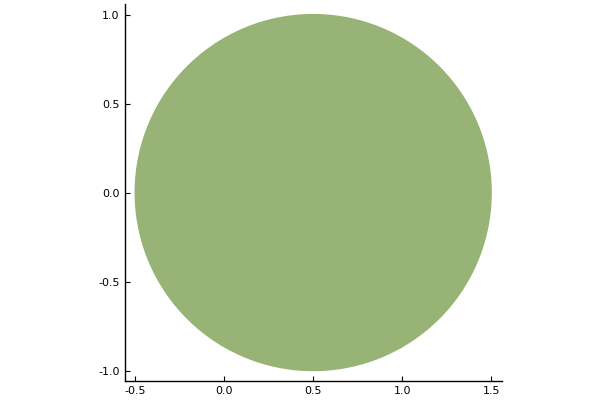

In [133]:
plot(body)

In [134]:
transpose(body.y)*(normb[2].*dsb)

-3.141362982503544

In [135]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [136]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 2.0943568232491048


In [137]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=Fields.Yang3)
Hmat,Emat = RegularizationMatrix(regop,f,w);

#### And now create the saddle-point system

In [138]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 300 constraints and
   State of type Nodes{Dual,616,616,Float64}
   Force of type ScalarData{300,Float64}


In [139]:
S = Matrix(PS.S);

#### Create some data structures for general use

In [140]:
ψb = ScalarData(X);
w = Nodes(Dual,size(g));
ψ = Nodes(Dual,w)
f = ScalarData(X);

In [141]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [142]:
Γ₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/Γ₀;
PC = I - oB*transpose(oB)*inv(S)/Γ₀;
k = 50 #298
eK = zeros(size(f))
eK[k] = 1.0;
#eK[k-1] = 0.25; eK[k] = 0.5; eK[k+1] = 0.25;
PK = I - oB*transpose(eK);

In [143]:
f0 = ScalarData(X);
f0 .= S\oB;

Normalize f0 to have circulation equal to 1,

$$ f_0 = \dfrac{S^{-1}o_B}{o_B^T S^{-1}o_B} $$

In [144]:
transpose(body.x)*(S\(PC*body.x) + normb[1].*dsb)

3.1819875927963173

In [145]:
-transpose(body.y)*(S\(PC*body.x))

-3.712308238590367e-16

In [146]:
-0.5*(transpose(body.x.*body.x)+transpose(body.y.*body.y))*(normb[1].*dsb)

1.5706814912517721

In [149]:
transpose(body.x)*(normb[1].*dsb),transpose(body.y)*(normb[2].*dsb)

(-3.1413629825035434, -3.141362982503544)

In [678]:
ξ = 2*body.x̃;

In [679]:
ds

0.020408163265306034

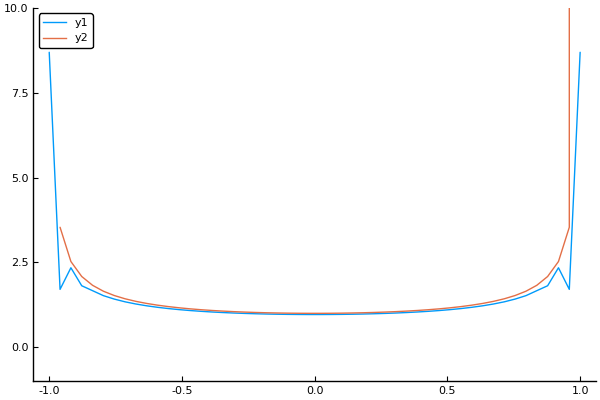

In [680]:
plot(ξ,(π/2)*f0./Γ₀/ds,ylim=(-10,1))
plot!(ξ,1.0 ./ sqrt.(1.0 .- ξ.^2),ylim=(-1,10))

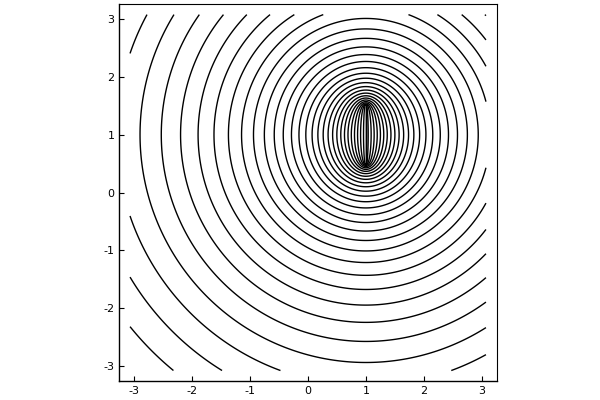

In [681]:
ψ .= -(L\(Hmat*f0)); #.+ transpose(yg .- body.cent[2])
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [682]:
S̃ = S*Diagonal(f0);

#### Now set the problem parameters

In [683]:
# The desired streamfunction on the circle surface
#ψb .= -(body.x .- body.cent[1]); # Translation in y direction
ψb .= -(body.y .- body.cent[2]); # Translation in -x direction
#ψb .= -0.5*((body.x .- body.cent[1]).^2+(body.y .- body.cent[2]).^2); # Rotation about centroid
ψb .= PC*ψb; # project out the circulation

# The desired circulation about the body
#Γ0 = 0;

In [684]:
transpose(oB)*(S\ψb)

-1.099120794378905e-14

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [685]:
f̃ = ScalarData(X);
#f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);
f̃ .= S̃\ψb;
#f̃ .= PK*(S̃\ψb);
#f̃ .= S̃\ψb;

f = f0∘f̃;

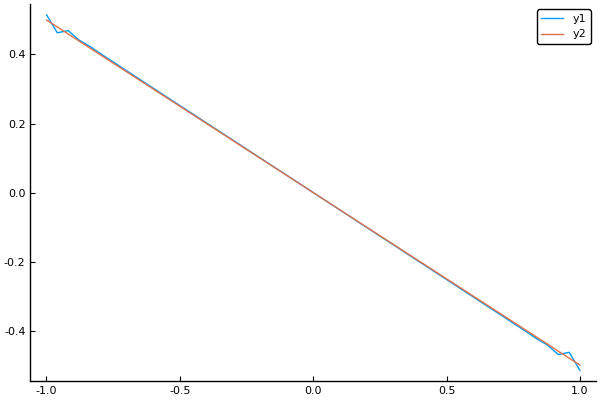

In [686]:
plot(ξ,-f̃*Γ₀*1/(2π))
plot!(ξ,-sin(α)*ξ/2)

#### Check that this `f` gives correct circulation

In [687]:
sum(f)

-1.0547118733938987e-14

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [443]:
#ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [688]:
ψ .= -(L\(Hmat*f)) .+ transpose(yg .- body.cent[2])  #.+ ψ₀;

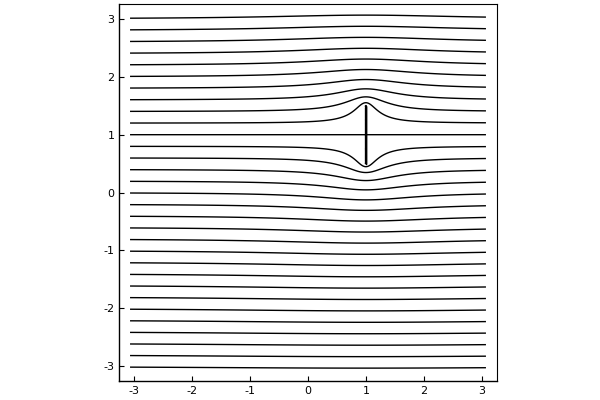

In [689]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [690]:
qgradq = Edges(Primal,ψ)
p = Nodes(Primal,ψ)
q = curl(ψ)
convective_derivative!(qgradq,q)
Lp = plan_laplacian(size(p),with_inverse=true)
p = -(Lp\(divergence(qgradq)));

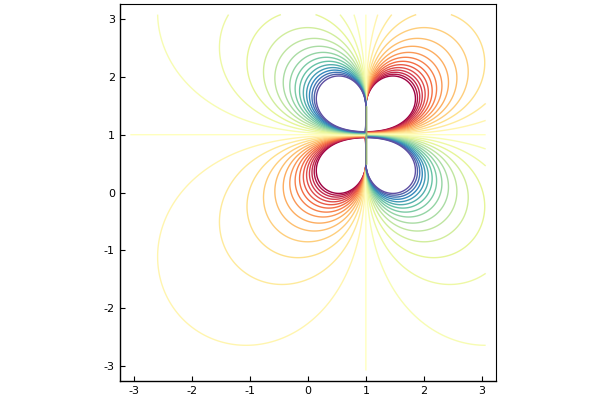

In [695]:
xu, yu = coordinates(q.u,g)
xv, yv = coordinates(q.v,g)
plot(xv,yv,q.v,levels=range(-1e-3,1e-3,length=31),clim=(-1e-3,1e-3))
plot!(body)

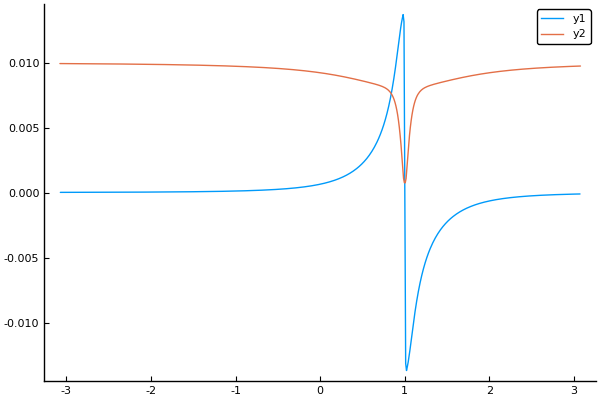

In [707]:
plot(xv,q.v[:,450])
plot!(xu,q.u[:,450])

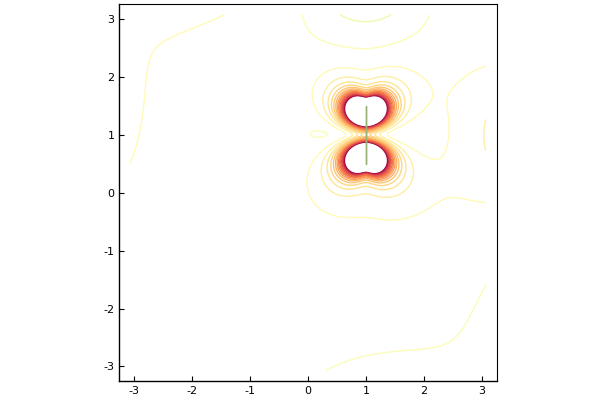

In [711]:
xc, yc = coordinates(p,g)
plot(xc,yc,p,levels=range(-1e-5,1e-5,length=30),clim=(-1e-5,1e-5))
plot!(body)

### Let's try an airfoil

In [56]:
?NACA4

search: NACA4 plan_laplacian plan_laplacian!



```
NACA4(cam,pos,thick[;np=20][,Xc=(0.0,0.0)][,len=1.0]) <: Body{N}
```

Generates points in the shape of a NACA 4-digit airfoil of chord length 1. The relative camber is specified by `cam`, the position of maximum camber (as fraction of chord) by `pos`, and the relative thickness by `thick`.

The optional parameter `np` specifies the number of points on the upper or lower surface. The optional parameter `Zc` specifies the mean position of the vertices (which is set to the origin by default). The optional parameter `len` specifies the chord length.

# Example

```jldoctest
julia> w = Bodies.NACA4(0.0,0.0,0.12);
```


In [213]:
c = 1.0
body = NACA4(0.0,0.0,0.12,np=50,len=c)

body = Plate(1.0,26)
ds = minimum(Bodies.dlength(body));


# Find the minimum arc length
#ds = maximum(Bodies.dlength(body))

# Move the shape
xc = 1.0; yc = 1.0
α = 20π/180
T = RigidTransform((xc,yc),-α)
T(body)

Plate with 26 points and length 1.0 and thickness 0.0
   Current position: (1.0,1.0)
   Current angle (rad): -0.3490658503988659


In [190]:
Xraw = zeros(length(body.x),2)
Xraw[:,1] .= body.x
Xraw[:,2] .= body.y
body = SplinedBody(Xraw,Δx)
ds = maximum(Bodies.dlength(body))

0.02034995112062553

In [214]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [215]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 1.9999999999999962


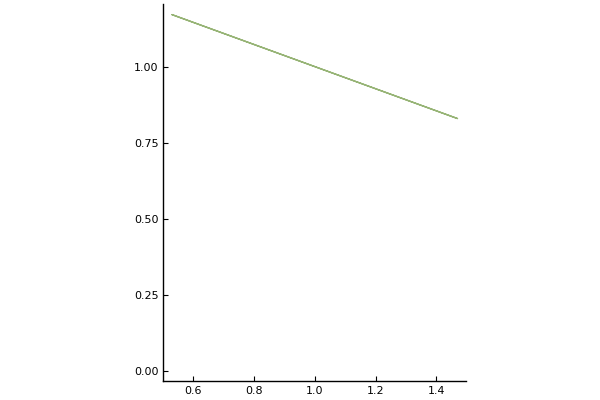

In [216]:
plot(body)

In [219]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=Fields.Yang3)
Hmat,Emat = RegularizationMatrix(regop,f,w);

#### And now create the saddle-point system

In [220]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 26 constraints and
   State of type Nodes{Dual,600,600,Float64}
   Force of type ScalarData{26,Float64}


#### Create some data structures for general use

In [221]:
ψb = ScalarData(X);
w = Nodes(Dual,size(g));
ψ = Nodes(Dual,w)
f = ScalarData(X);

In [222]:
oB = zeros(size(f))
oB .= 1;

In [223]:
τ = zeros(size(f))
τ[end] = 1
#τ[2] = 1/2
#τ[end] = 1/2;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [224]:
S = Matrix(PS.S);

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [225]:
#S₀ = transpose(oB)*(S\oB)
#T = S - oB*transpose(oB)/S₀;
S₀ = transpose(τ)*(S\τ)
T = S - τ*transpose(τ)/S₀;

#### Now set the problem parameters

In [226]:
# free stream
U∞ = 1

# The desired streamfunction on the circle surface
ψb .= -U∞*(body.y .- body.cent[2]) # Translation in x direction

# The desired circulation about the circle
Γ0 = -π*c*U∞*sin(α)

γs = 0;

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [227]:
#f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);
f .= S\(T*(S\ψb) .+ ds*γs*τ/S₀);

In [228]:
f[end]

1.5983608335334364e-16

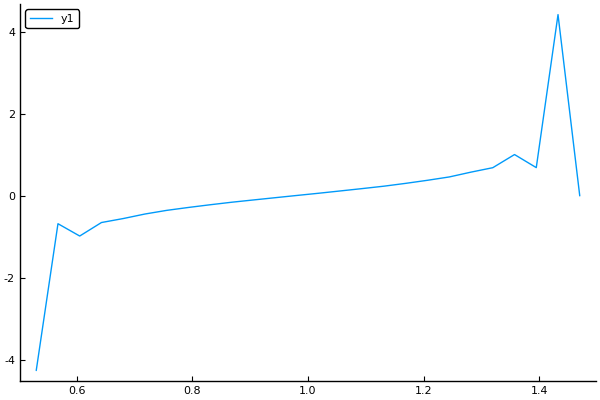

In [229]:
plot(X.u,f./ds)

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [230]:
#ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))
ψ₀ = -1/S₀*(ds*γs - transpose(τ)*(S\ψb))

0.0442877969767877

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [231]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

In [232]:
xg, yg = coordinates(ψ,g)
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ yg' .- body.cent[2]; # adding the free-stream streamfunction

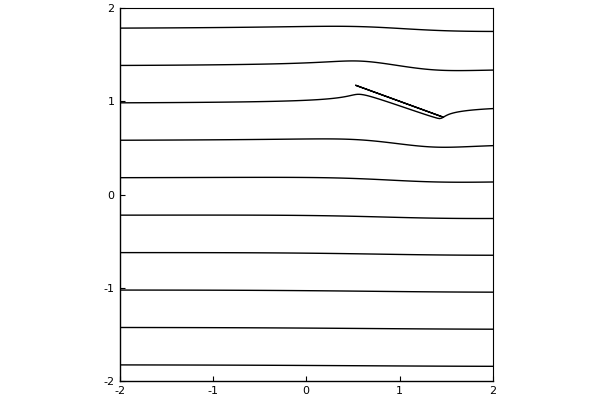

In [234]:
plot(xg,yg,ψtot,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=1,linecolor=:black,xlim=(-2,2),ylim=(-2,2))